# Data structures for single-cell and multi-modal data

In this exercise, we'll get familiar with the AnnData and MuData frameworks for working with single-cell and multi-modal data in Python.
These frameworks make working with data much more convenient compared to using for example plain Numpy arrays or Pandas DataFrames. In the last part of the exercise, we'll process some actual data using these frameworks.

## AnnData

You can think of an AnnData object as a data matrix of observations x variables with additional metadata. Visit the [documentation](https://anndata.readthedocs.io/en/latest/index.html) for a [quick introduction](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html)

To demonstrate basic usage, we first import relevant Python packages and then create an AnnData object with random data.

In [1]:
import anndata
import numpy as np

# Simulate count matrix with 100 rows (observations) and 2000 columns (features)
counts = np.random.poisson(1, size=(100, 2000))
adata = anndata.AnnData(counts)
adata

AnnData object with n_obs × n_vars = 100 × 2000

The .X attribute contains the data matrix.

In [2]:
adata.X

array([[1, 1, 0, ..., 2, 2, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 1, 2, ..., 0, 1, 1],
       ...,
       [1, 0, 3, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]])

For very large and sparse data matrices (many zeros), it's recommended to convert the numpy array to a sparse matrix object first, this is more memory efficient.

In [3]:
from scipy.sparse import csr_matrix

# convert counts to a sparse matrix
counts_sparse = csr_matrix(counts)
adata_sparse = anndata.AnnData(counts_sparse)
adata_sparse

AnnData object with n_obs × n_vars = 100 × 2000

Now the .X attribute is a sparse matrix.

In [4]:
adata_sparse.X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 126516 stored elements and shape (100, 2000)>

Our AnnData object does not have any metadata yet. We can assign names to observations (cells) and variables (genes).

In [5]:
adata.obs_names = [f"Cell_{i}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i}" for i in range(adata.n_vars)]
adata.obs_names

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5', 'Cell_6',
       'Cell_7', 'Cell_8', 'Cell_9', 'Cell_10', 'Cell_11', 'Cell_12',
       'Cell_13', 'Cell_14', 'Cell_15', 'Cell_16', 'Cell_17', 'Cell_18',
       'Cell_19', 'Cell_20', 'Cell_21', 'Cell_22', 'Cell_23', 'Cell_24',
       'Cell_25', 'Cell_26', 'Cell_27', 'Cell_28', 'Cell_29', 'Cell_30',
       'Cell_31', 'Cell_32', 'Cell_33', 'Cell_34', 'Cell_35', 'Cell_36',
       'Cell_37', 'Cell_38', 'Cell_39', 'Cell_40', 'Cell_41', 'Cell_42',
       'Cell_43', 'Cell_44', 'Cell_45', 'Cell_46', 'Cell_47', 'Cell_48',
       'Cell_49', 'Cell_50', 'Cell_51', 'Cell_52', 'Cell_53', 'Cell_54',
       'Cell_55', 'Cell_56', 'Cell_57', 'Cell_58', 'Cell_59', 'Cell_60',
       'Cell_61', 'Cell_62', 'Cell_63', 'Cell_64', 'Cell_65', 'Cell_66',
       'Cell_67', 'Cell_68', 'Cell_69', 'Cell_70', 'Cell_71', 'Cell_72',
       'Cell_73', 'Cell_74', 'Cell_75', 'Cell_76', 'Cell_77', 'Cell_78',
       'Cell_79', 'Cell_80', 'Cell_81', 'Cell_82',

Now we can subset the AnnData object using cell and gene names.

In [6]:
adata[["Cell_1", "Cell_10"], ["Gene_5", "Gene_1900"]]

View of AnnData object with n_obs × n_vars = 2 × 2

Note that we obtained a view of an AnnData object. The view does not store any data but points to the original AnnData object instead to save memory. The view will automatically convert itself to a full AnnData object by copying the relevant subset of the original object if we try to add some data to the view.

We can also add some metadata describing the observations. To demonstrate this, we randomly assign one of three random cell types to a column in the `.obs` attribute which is a Pandas DataFrame.

In [7]:
adata.obs["cell_type"] = np.random.choice(["B", "T", "Monocyte"], size=(adata.n_obs,))
adata.obs

,cell_type
Cell_0,T
Cell_1,T
Cell_2,T
Cell_3,B
Cell_4,T
...,...
Cell_95,B
Cell_96,T
Cell_97,Monocyte
Cell_98,B


Note that the description of the AnnData object now includes the new column.

In [8]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'

We can also subset the AnnData object using boolean indexing. For example, we can get all B cells.

In [9]:
bdata = adata[adata.obs["cell_type"] == "B"]
bdata

View of AnnData object with n_obs × n_vars = 38 × 2000
    obs: 'cell_type'

AnnData can store multiple data matrices in the `.layers` attribute. This is useful if one wants to keep both original and transformed, e.g. normalized, data. All matrices must have the same shape as the original `.X`.

In [10]:
adata.layers["log_transformed"] = np.log1p(adata.X)
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    layers: 'log_transformed'

### Exercise
Try to add a new layer called `counts` to the AnnData object with the reverse transformation, `np.expm1()`.

In [11]:
# Your solution here
# ...


Inspect the resulting matrix. Is it different to the original values in `.X`?

In [12]:
# Your solution here
# ...

Now repeat the transformation steps with the `adata_sparse` object. To display the values of a sparse matrix, you can use the `.toarray()` method.

## MuData

MuData objects contain a dictionary of AnnData objects and are used for multimodal data. AnnData objects within a MuData container are aligned and can be jointly subsetted.

To demonstrate this, we will use the `adata` and `bdata` objects from above. Since MuData assumes that variables are unique to each modality, we first change `bdata`'s variable names and then create a MuData object.

In [13]:
import mudata
mudata.set_options()

# rename the variable names in bdata to "Protein_0", "Protein_1", ...
bdata.var_names = [f"Protein_{i}" for i in range(bdata.n_vars)]
bdata.var_names

Index(['Protein_0', 'Protein_1', 'Protein_2', 'Protein_3', 'Protein_4',
       'Protein_5', 'Protein_6', 'Protein_7', 'Protein_8', 'Protein_9',
       ...
       'Protein_1990', 'Protein_1991', 'Protein_1992', 'Protein_1993',
       'Protein_1994', 'Protein_1995', 'Protein_1996', 'Protein_1997',
       'Protein_1998', 'Protein_1999'],
      dtype='object', length=2000)

In [14]:
# create a multimodal MuData object from the two AnnData objects
mdata = mudata.MuData({"rna": adata, "prot": bdata})
mdata

MuData object with n_obs × n_vars = 100 × 4000
  2 modalities
    rna:	100 x 2000
      obs:	'cell_type'
      layers:	'log_transformed'
    prot:	38 x 2000
      obs:	'cell_type'
      layers:	'log_transformed'

We can access individual modalities using a dictionary-like interface.

In [15]:
mdata["rna"]

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    layers: 'log_transformed'

We can subset the MuData object using integer or string based indexing.

In [16]:
mdata[20:42, ["Gene_42", "Protein_42"]]

View of MuData object with n_obs × n_vars = 22 × 2
  2 modalities
    rna:	22 x 1
      obs:	'cell_type'
      layers:	'log_transformed'
    prot:	6 x 1
      obs:	'cell_type'
      layers:	'log_transformed'

Note that less than the expected 22 cells from the `prot` modality are included in the subset. This is because we created the `prot` modality from only a subset of all cells, and MuData uses the cell names (`.obs_names`) to mach observations in different modalities to each other.

# AnnData and MuData in practice

[Scanpy](https://scanpy.readthedocs.io/) is a Python frame work for the analysis of single-cell data and works with AnnData and MuData objects. [Muon](https://muon.readthedocs.io/) is a Python framework for the analysis of single-cell multi-modal data. We will demonstrate some ways to use the combination of Scanpy/AnnData/MuData using a [publicly available CITE-seq data set of peripheral blood mononuclear cells](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_pbmc_protein_v3).

In [17]:
import scanpy as sc
import muon as mu

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

We first load the data. The `mudatasets` package is a convenient way to access some example data sets. Note that 10x uses common gene names as variable names. Some genes share a common name, which results in a warning at this step and may lead to errors further downstream. We therefore generate unique names by appending a number to duplicated names.

In [18]:
import mudatasets as mds
mdata = mds.load("pbmc5k_citeseq", backed=False, full=True)
mdata.var_names_make_unique()

■ File filtered_feature_bc_matrix.h5 from pbmc5k_citeseq has been found at /Users/martin/mudatasets/pbmc5k_citeseq/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File minipbcite.h5mu from pbmc5k_citeseq has been found at /Users/martin/mudatasets/pbmc5k_citeseq/minipbcite.h5mu
■ Checksum is validated (md5) for minipbcite.h5mu
■ File pbmc5k_citeseq_processed.h5mu from pbmc5k_citeseq has been found at /Users/martin/mudatasets/pbmc5k_citeseq/pbmc5k_citeseq_processed.h5mu


/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudatasets/core.py:69: UserWarning: ■ Checksum does not match (md5), will re-download pbmc5k_citeseq_processed.h5mu
  warn(
100%|██████████| 46866/46866 [00:13<00:00, 3386.42it/s, 385.4MiB, pbmc5k_citeseq_processed.h5mu, pbmc5k_citeseq]


■ Loading filtered_feature_bc_matrix.h5...


/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


The MuData object has two modalities:

In [19]:
mdata

MuData object with n_obs × n_vars = 5247 × 33570
  var:	'gene_ids', 'feature_types', 'genome'
  2 modalities
    rna:	5247 x 33538
      var:	'gene_ids', 'feature_types', 'genome'
    prot:	5247 x 32
      var:	'gene_ids', 'feature_types', 'genome'

We can also see an interactive summary of the MuData object in the HTML format:

In [20]:
with mudata.set_options(display_style="html"):
    display(mdata)

rna,bool,numpy.ndarray,
prot,bool,numpy.ndarray,


## QC and preprocessing for RNA

We can now run Scanpy methods on individual modalities. For example, let's do some quality control of the scRNAseq data.

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/seaborn/

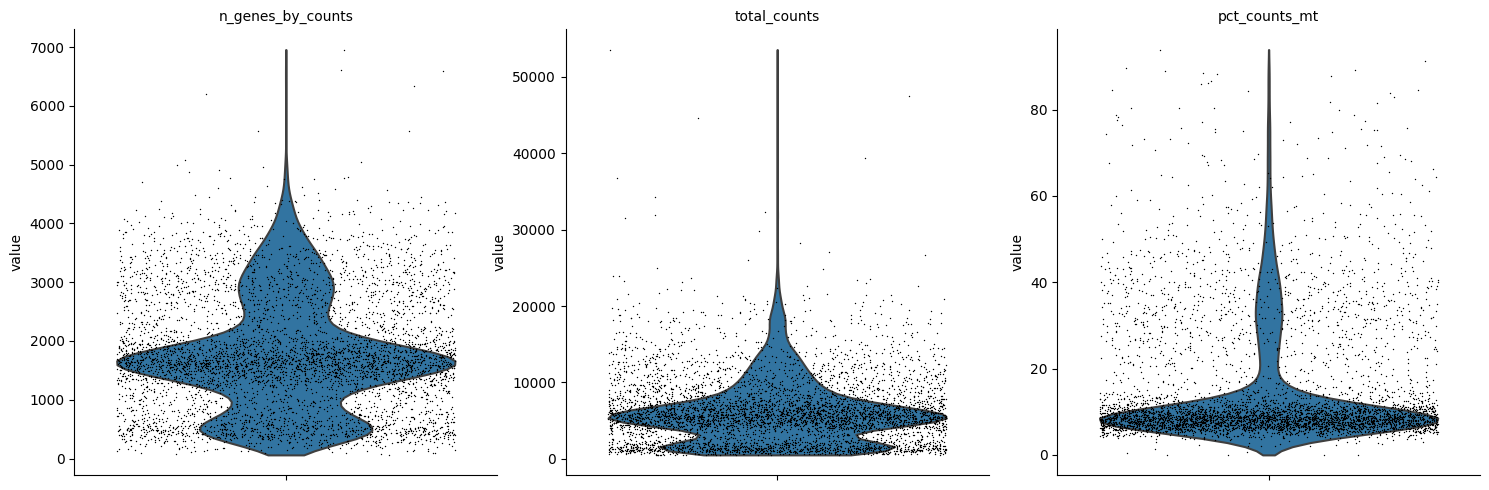

In [21]:
# create a new column in the .var DataFrame of the "rna" modality that indicates whether a gene is mitochondrial
mdata["rna"].var["mt"] = mdata["rna"].var_names.str.startswith("MT-")

# calculate QC metrics for the "rna" modality, details here: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html
sc.pp.calculate_qc_metrics(mdata["rna"], qc_vars=["mt"], percent_top=None, log1p=None, inplace=True)

# plot: (i) number of genes expressed per cell, (ii) total counts per cell, and (iii) percentage of mitochondrial genes
sc.pl.violin(mdata["rna"], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

We can remove genes that are expressed in less than 3 cells.

In [22]:
mu.pp.filter_var(mdata["rna"], 'n_cells_by_counts', lambda x: x >= 3)

We remove cells that
- have less than 200 or more than 500 genes expressed
- have a total RNA count of less than 1500 or more than 15000
- have a fraction of mitochondrial counts higher than 20 % (indicates poor sample quality / apoptotic cells)

In [23]:
mu.pp.filter_obs(mdata["rna"], 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
mu.pp.filter_obs(mdata["rna"], 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(mdata["rna"], 'pct_counts_mt', lambda x: x < 20)

Let’s see how the data looks after filtering:

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/seaborn/

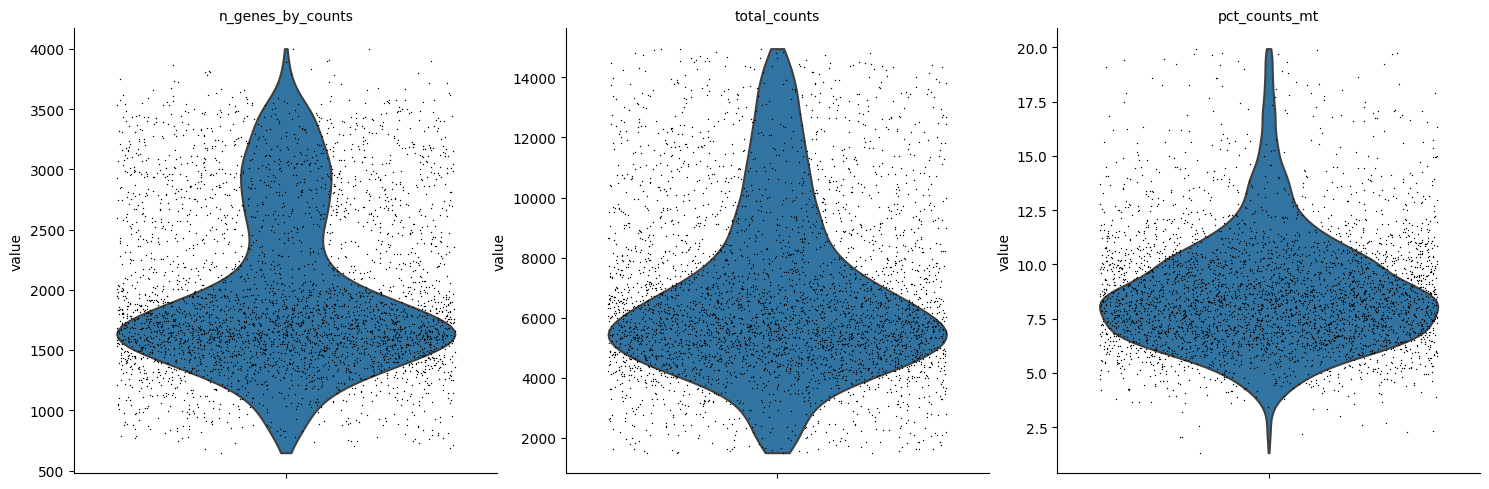

In [24]:
sc.pl.violin(mdata["rna"], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

Many methods require normalized and log-transformed counts. We save the raw counts in a new layer before normalizing and transforming the `.X` matrix.

In [25]:
mdata["rna"].layers["counts"] = mdata["rna"].X.copy()
sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])

We can now select highly variable genes that will be used for downstream analysis. The result from the highly variable genes selection is stored ins the `highly_variable` column of the `.var` attribute.

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


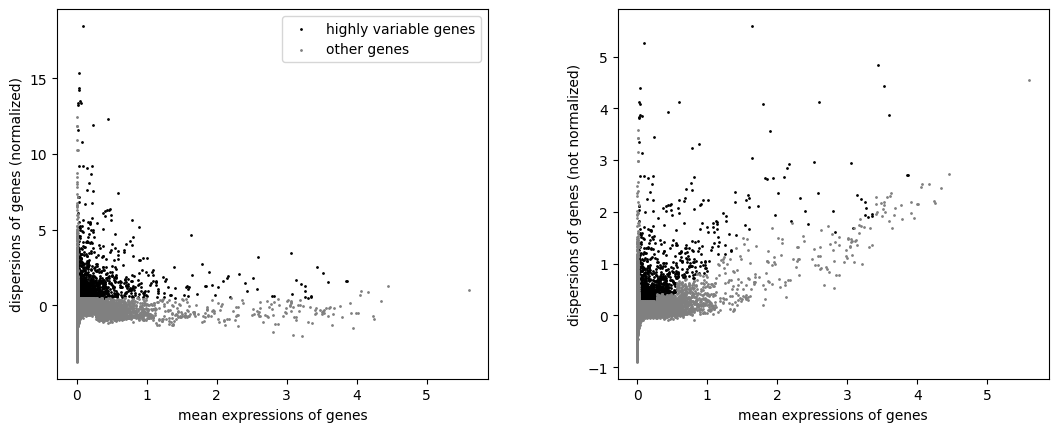

In [26]:
sc.pp.highly_variable_genes(mdata["rna"], min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(mdata["rna"])

We can now run some analyses. For example, we can run a PCA and plot expression of immune cell markers to see if cell types are separated by PCA. The `.pca` method will automatically only consider the highly variable genes from the last step.

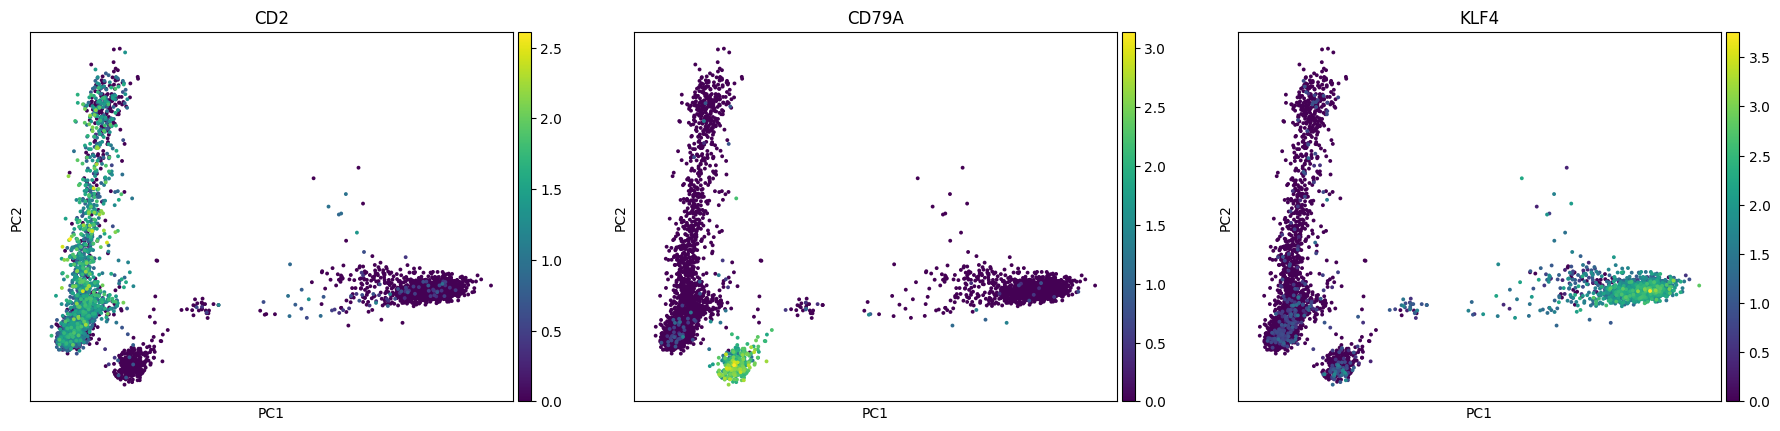

In [27]:
sc.tl.pca(mdata["rna"])

# plot the first two principal components, colored by marker genes
sc.pl.pca(mdata["rna"], color=['CD2', 'CD79A', 'KLF4'])

We can also check how much variance is captured by the individual principal components.

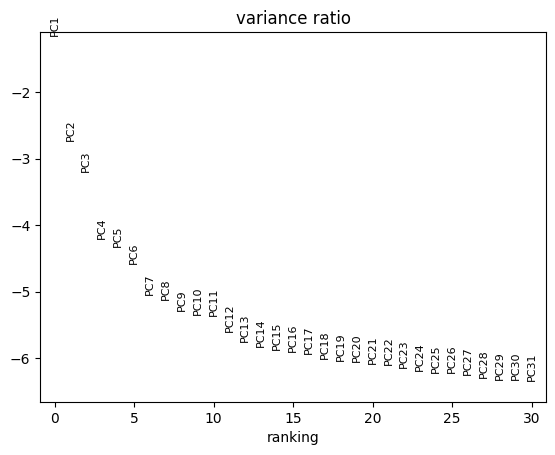

In [28]:
sc.pl.pca_variance_ratio(mdata["rna"], log=True)

Finally, we can create a neighborhood graph based on the first 20 PCs and use it to perform Leiden clustering and UMAP visualization.

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


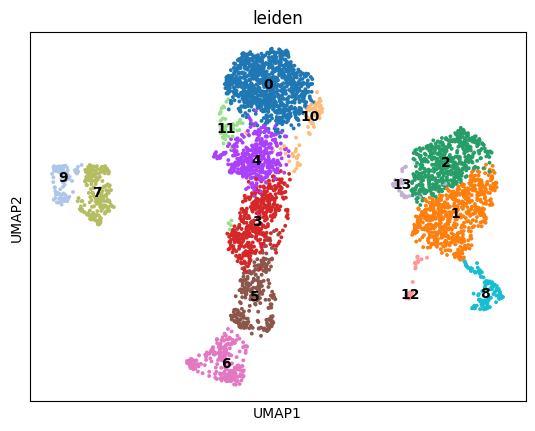

In [29]:
# use the first 20 principal components for clustering
sc.pp.neighbors(mdata["rna"], n_neighbors=10, n_pcs=20)
sc.tl.leiden(mdata["rna"], resolution=0.75)

# plot the UMAP embedding colored by the Leiden clusters
sc.tl.umap(mdata["rna"])
sc.pl.umap(mdata["rna"], color="leiden", legend_loc="on data")

Using muon, we can plot the UMAP from the RNA modality, but color it by a variable from another modality.

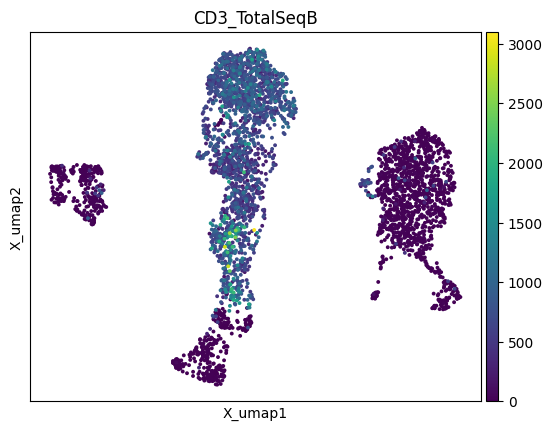

In [30]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD3_TotalSeqB"])

We can save our MuData object to disk. This will retain all computed quantities, such as the neighborhood graph and cluster assignment. To save some space, we compress the data.

In [31]:
mdata.write_h5mu("pbmc5k.h5mu", compression="gzip", compression_opts=9)

# Exercises
1. Find a way to read an individual modality (e.g. "rna") from the previously saved `.h5mu` file without first loading the full data set and then extracting the modality. Hint: Look for a method similar to `mudata.read_h5mu` in the documentation.
2. Try to reproduce the cell type annotation part of the [muon tutorial](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html).
3. The above tutorial stores cell type annotation in the RNA modality. But a cell type does not depend on the modality. Move the cell type annotation from the RNA modality to the global MuData object. Hint: you may need to read up on `MuData.pull_obs()`.
4. Repeat the Leiden clustering with different settings. Save the results of all clusterings in the same object and plot them.
5. Write the RNA data to disk in a format than can be read by someone only familiar with scanpy/AnnData.